<a href="https://colab.research.google.com/github/Weff24/PrivacyPlate/blob/main/privacy_plate_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Notebook Setups

## 1.1 Install Environment Requirements

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install -U yolov5

In [191]:
import cv2
import pytesseract
import yolov5

pytesseract.pytesseract.tesseract_cmd = ( r'/usr/bin/tesseract' )

In [192]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [193]:
import xml.etree.ElementTree as ET
import os
import sys
from collections import defaultdict

from pathlib import Path
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import matplotlib.patches as patches
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

## 1.2 Setup Methods

In [194]:
### Extraction Method ###
def extract_license_plate_text(image_path):
    # Read the image using OpenCV
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding or other preprocessing techniques if needed
    # Example: gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    # Use Tesseract OCR to extract text
    text = pytesseract.image_to_string(gray, config='--psm 7 --oem 1')

    return text

### Loading Model For Yolo ###
def load_model_bounding():
  model = yolov5.load('keremberke/yolov5m-license-plate')

  # set model parameters
  model.conf = 0.5  # NMS confidence threshold
  model.iou = 0.45  # NMS IoU threshold
  model.agnostic = False  # NMS class-agnostic
  model.multi_label = False  # NMS multiple labels per box
  model.max_det = 1000  # maximum number of detections per image

  return model

### Show Bounding Boxes Using Yolo ###
def bounding_box_show(image_path, model):
  # perform inference
  results = model(image_path, size=640)

  # inference with test time augmentation
  results = model(image_path, augment=True)

  # parse results
  predictions = results.pred[0]
  boxes = predictions[:, :4] # x1, y1, x2, y2
  scores = predictions[:, 4]
  categories = predictions[:, 5]

  # show detection bounding boxes on image
  results.show()

  return boxes

# 2. Image Blurring

In [195]:
# Round up to nearest odd integer for Gaussian Blur kernel size
def to_nearest_odd(n):
    if n % 2 == 0:
        return n + 1
    return n

In [196]:
# Path to annotation folder
annot_dir_path = Path("/content/drive/MyDrive/01-License Plates/annotations")

if not annot_dir_path.exists():
  print("Annotation directory path does not exist")
  sys.exit(1)

# Extract the box from xml files
box_locations = defaultdict(list)
box_sizes = defaultdict(list)
box_elements = ['xmin', 'ymin', "xmax", "ymax"] # order of the box location
box_size_elements = ['width', 'height'] # order of image size

for path in os.listdir(annot_dir_path):
    tree = ET.parse(f'{annot_dir_path}/{path}')  # Replace 'your_xml_file.xml' with your XML file path
    root = tree.getroot()

    # Get key from XML
    xml_ind =int(path[4:-4])

    for element in box_elements:
        box_locations[xml_ind].append(int(root.find('object').find('bndbox').find(element).text))

    for element in box_size_elements:
        box_sizes[xml_ind].append(int(root.find('size').find(element).text))

# Check dimensions of images
max_w = 0
max_h = 0
for w, h in box_sizes.values():
    if max_w < w:
        max_w = w
    if max_h < h:
        max_h = h

print('Max Width = ', max_w)
print('Max Height = ', max_h)

Max Width =  600
Max Height =  531


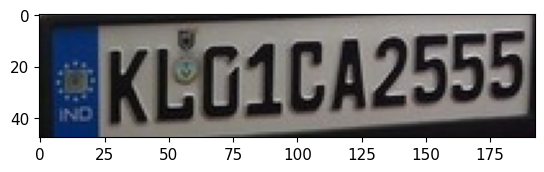

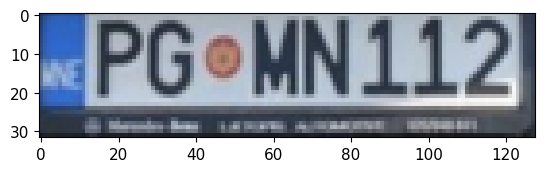

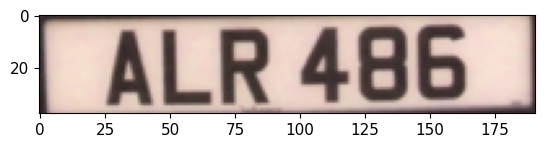

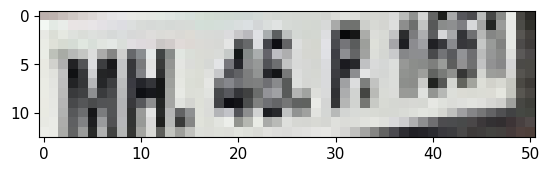

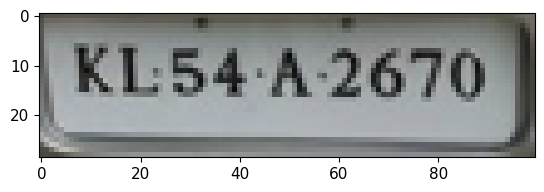

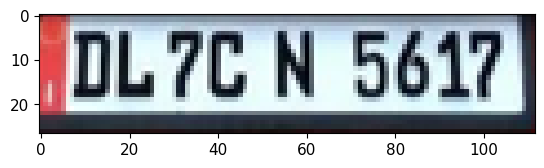

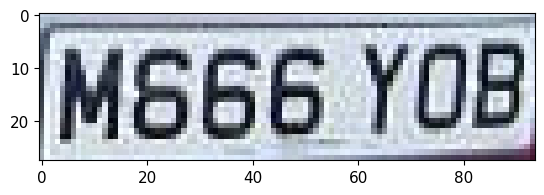

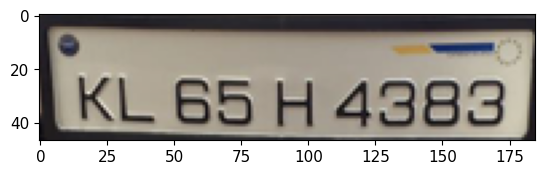

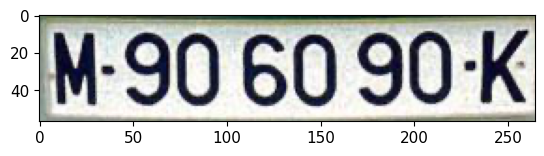

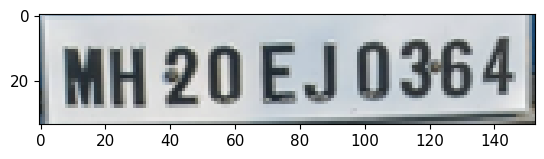

In [197]:
%matplotlib inline

###
###
### Change image_num to obfuscate different images
### Examples: 0, 1, 48, 59, 78, 159, 161, 212, 307, 333
###
###
image_num = 1
img_dir_path = Path("/content/drive/MyDrive/01-License Plates/paddedimages")
# path = f"Cars{image_num}.png"
image_nums = [0, 1, 48, 59, 78, 159, 161, 212, 307, 333]
# image_nums = range(0, 50)

if not img_dir_path.exists():
  print("Image directory path does not exist")
  sys.exit(1)


cropped_plate_images = []
plate_images = []

for image_num in image_nums:
    path = f"Cars{image_num}.png"
    plate_image = mpimg.imread(f"{img_dir_path}/{path}")
    fig, ax = plt.subplots()

    box = box_locations[int(path[4:-4])]
    cropped_plate_image = plate_image[box[1]:box[3], box[0]:box[2]]

    ax.imshow(cropped_plate_image)
    plt.show()

    plate_images.append((plate_image, box))
    cropped_plate_images.append((cropped_plate_image, box))

    plt.close()

<ipython-input-198-4d463d6b7c64>:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


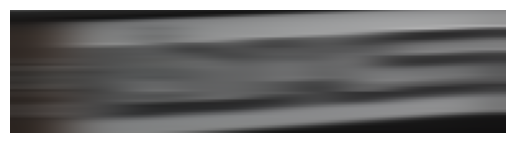

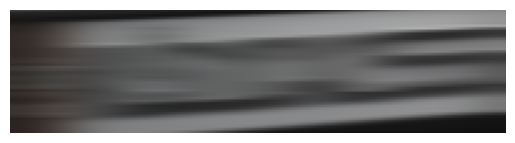

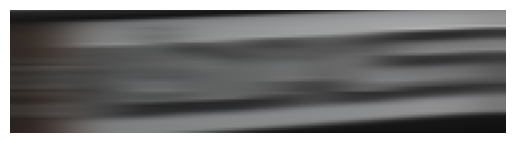

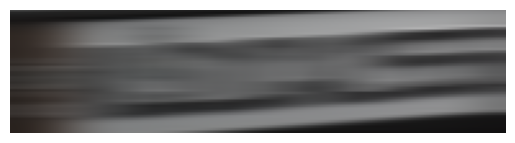

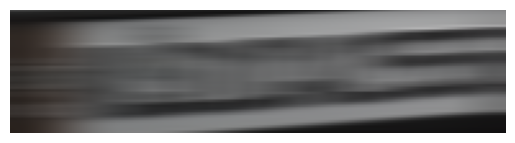

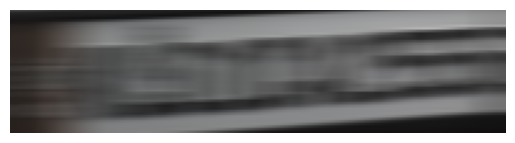

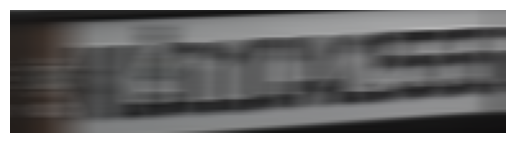

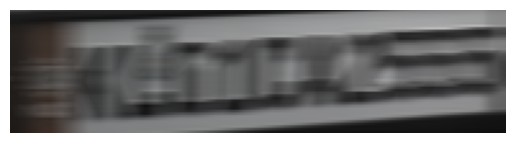

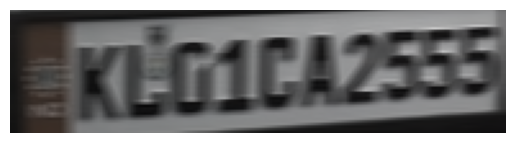

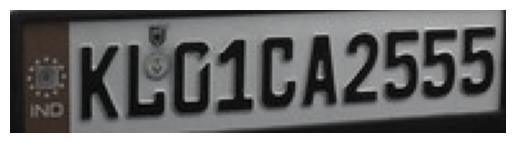

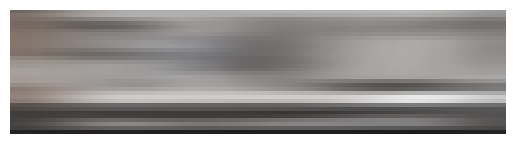

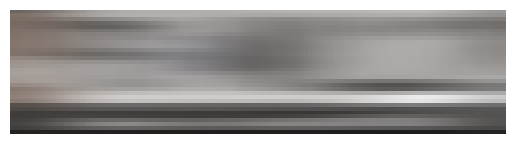

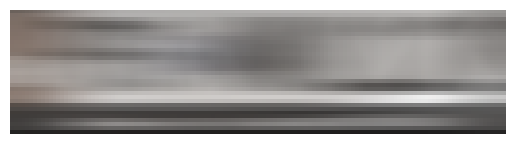

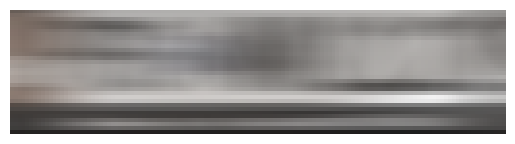

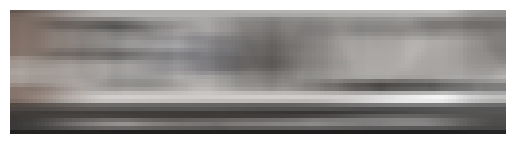

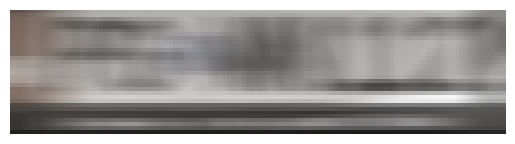

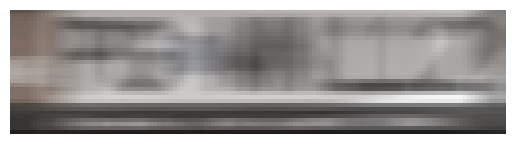

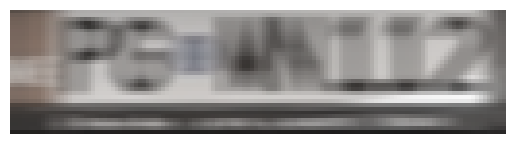

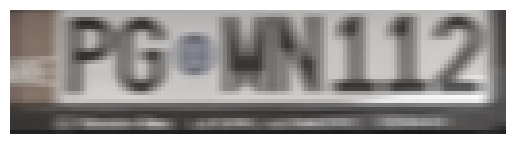

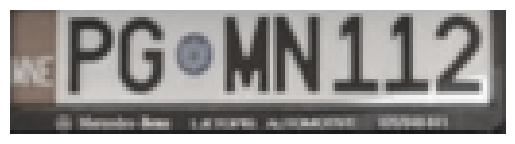

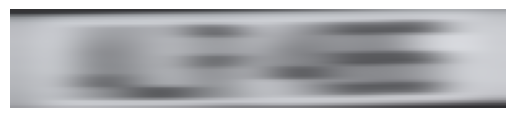

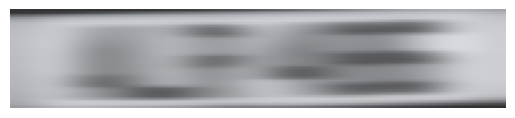

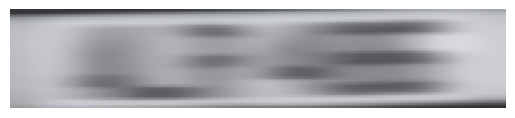

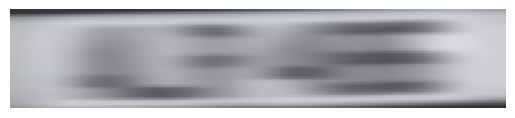

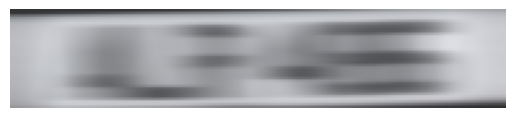

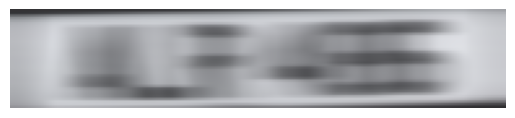

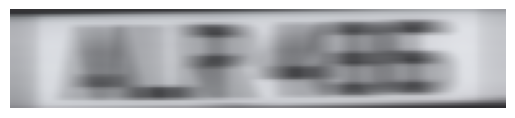

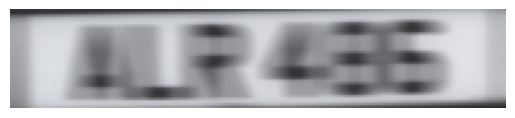

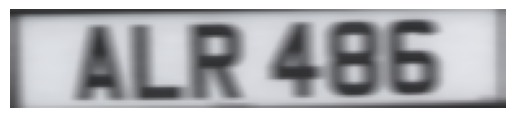

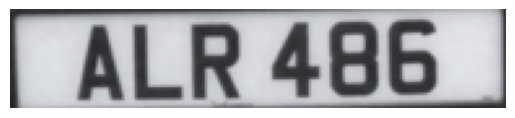

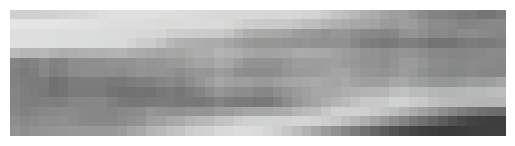

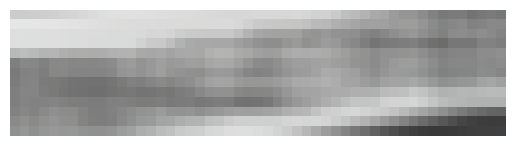

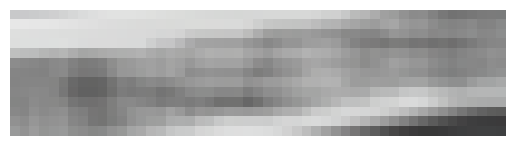

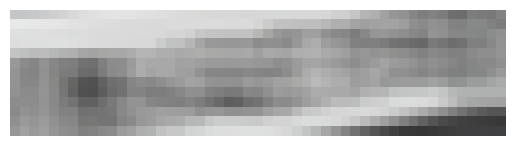

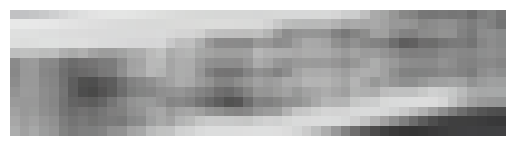

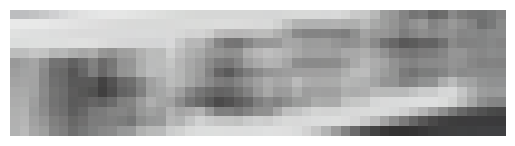

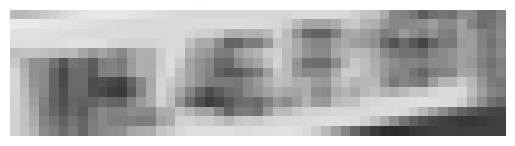

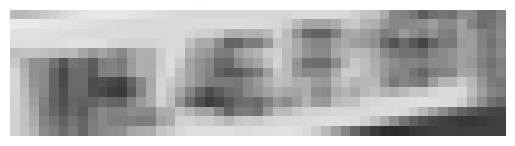

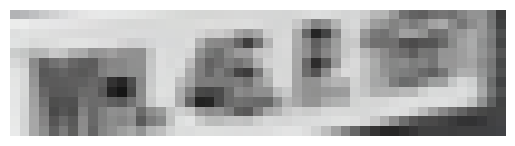

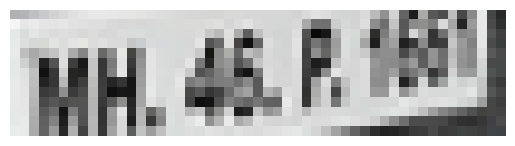

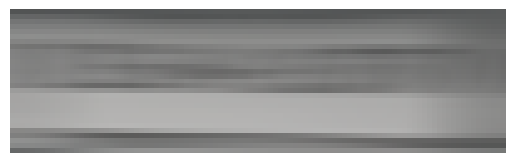

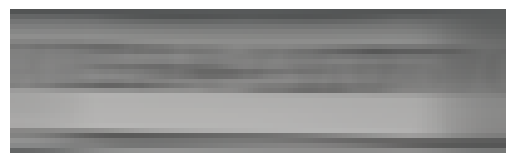

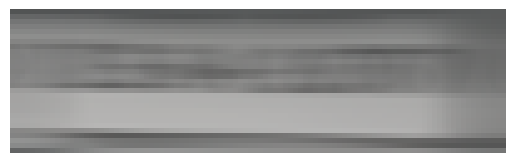

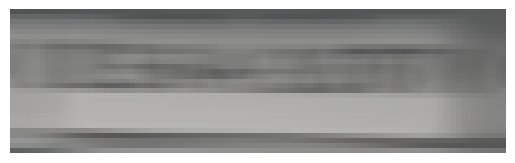

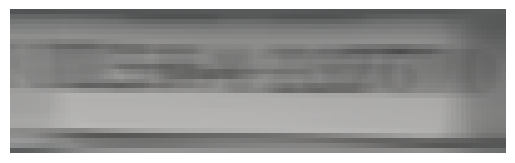

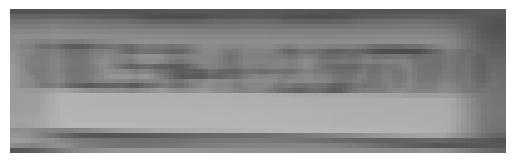

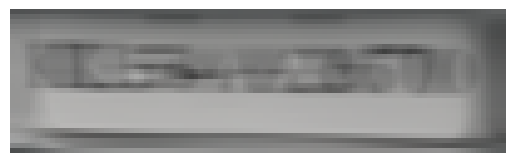

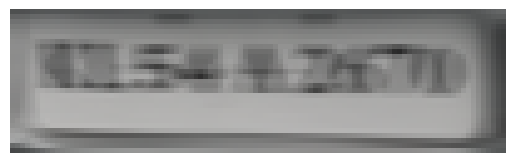

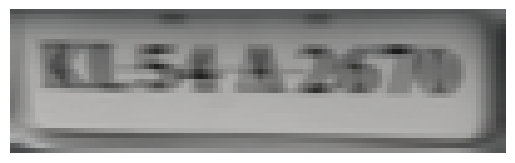

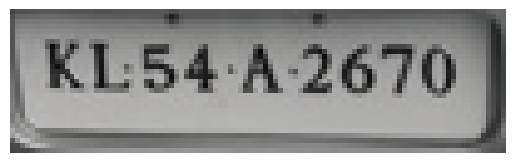

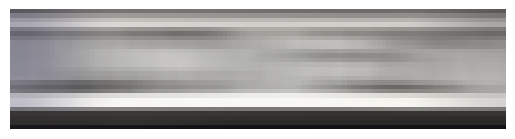

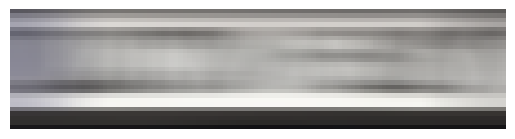

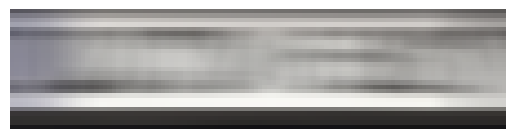

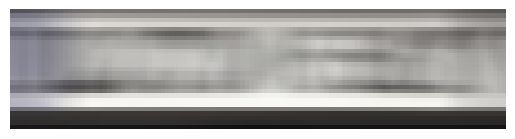

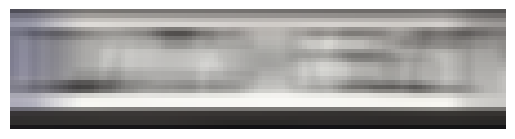

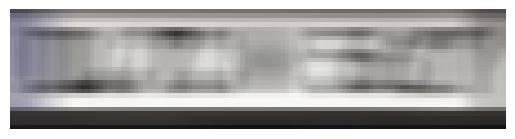

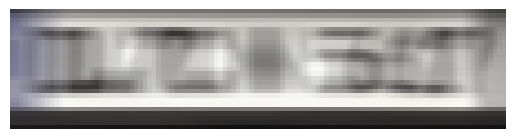

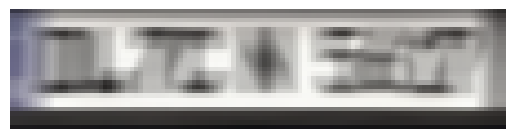

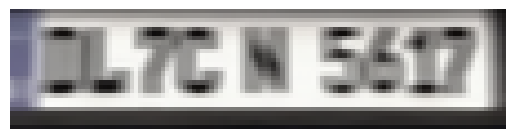

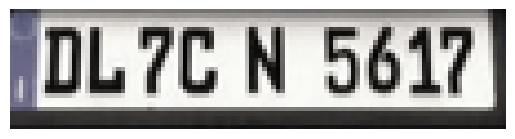

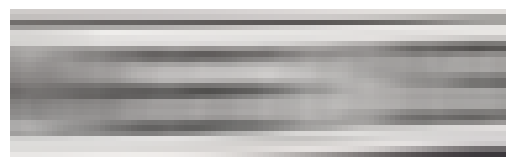

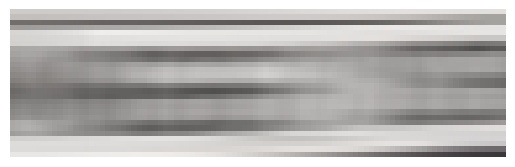

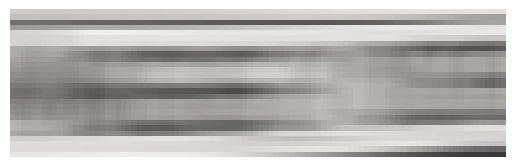

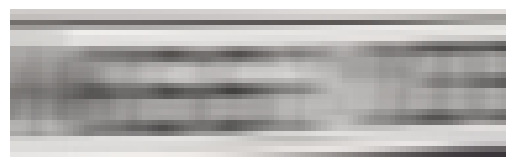

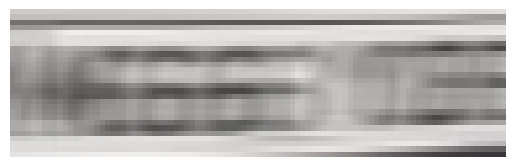

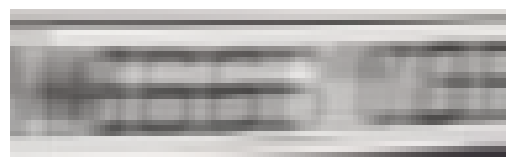

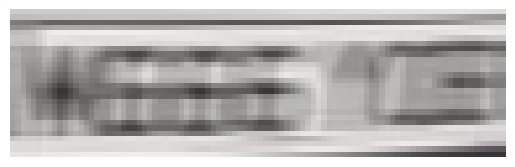

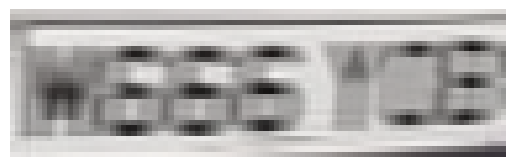

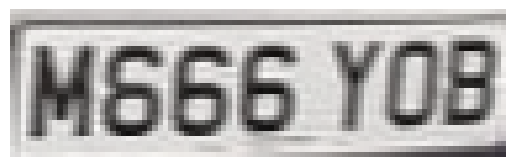

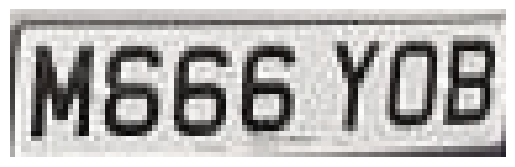

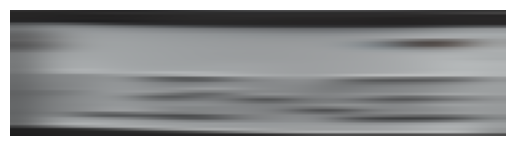

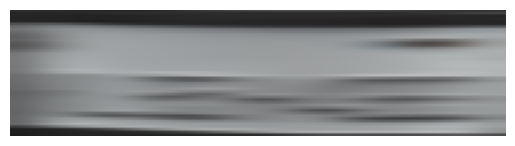

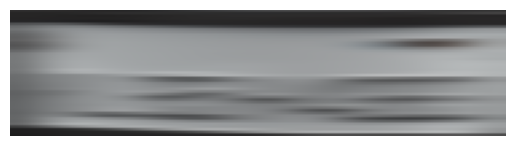

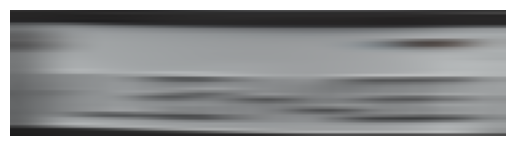

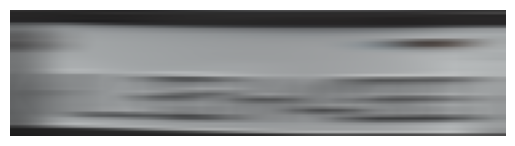

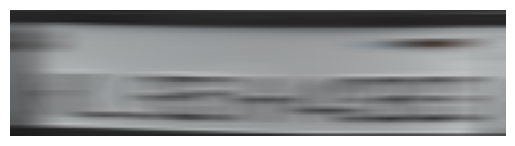

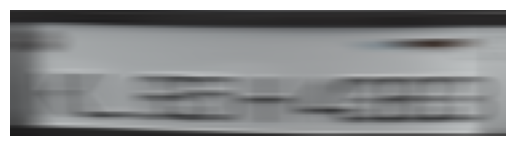

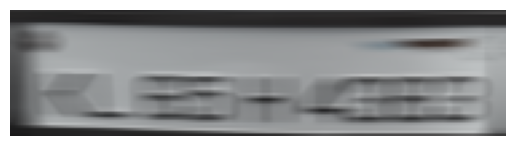

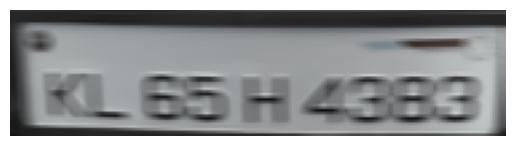

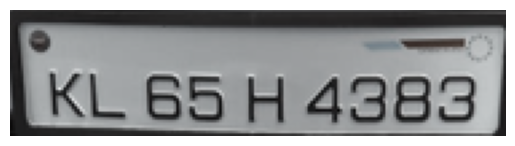

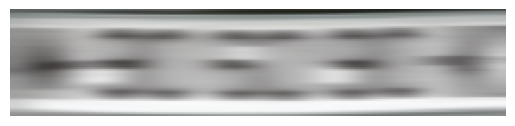

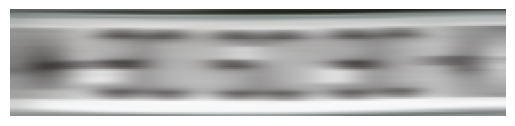

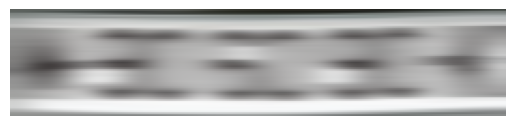

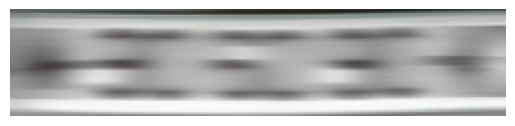

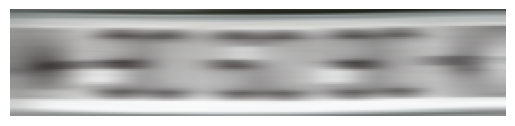

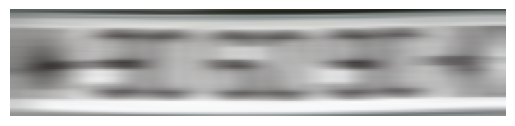

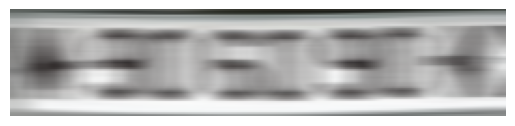

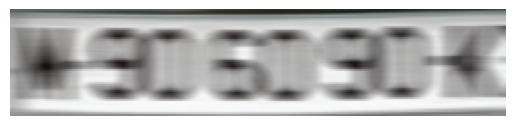

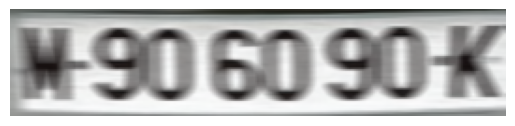

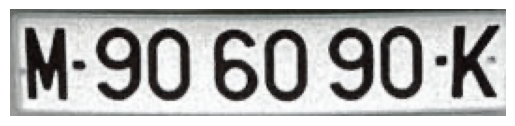

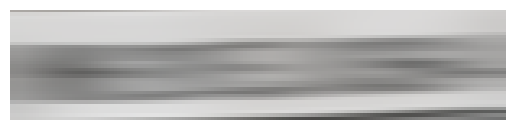

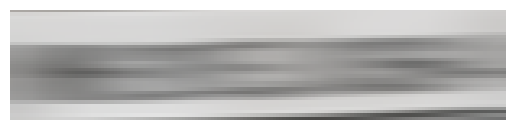

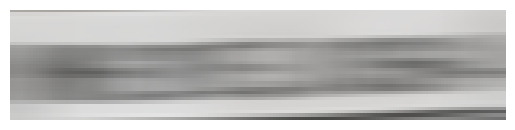

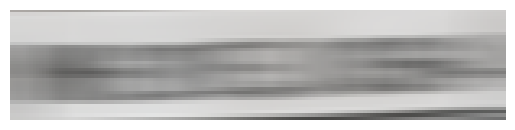

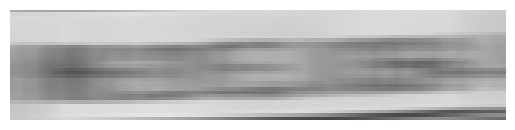

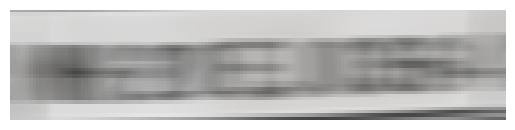

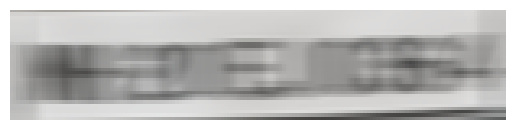

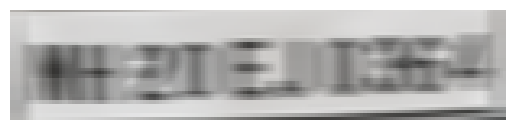

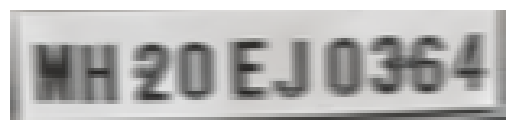

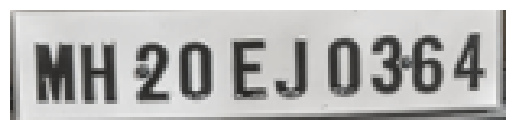

In [198]:
import copy

num_blur_levels = 10
# final_images = [[0] * (num_blur_levels)] * len(cropped_plate_images)
final_images = []

for i in range(len(cropped_plate_images)):
    final_images_row = [0] * (num_blur_levels)

    for blur_level in range(0, num_blur_levels):
        # Blur plate image
        cropped_plate_image = cropped_plate_images[i][0]
        cropped_plate_image_tensor = torch.from_numpy(cropped_plate_image)

        kernel_size = [5, to_nearest_odd((cropped_plate_image_tensor.size()[1] - cropped_plate_image_tensor.size()[1] * (blur_level) // (num_blur_levels - 1)) // 3)]
        sigma = 10
        blurred_plate_image = transforms.functional.gaussian_blur(cropped_plate_image_tensor, kernel_size, sigma).numpy()

        # Save cropped and blurred image
        fig, ax = plt.subplots()
        plt.axis("off")
        ax.imshow(blurred_plate_image)
        # plt.savefig(f"/content/drive/MyDrive/01-License Plates/croppedimages/CroppedCar{blur_level}.png")
        plt.savefig(f"/content/drive/MyDrive/01-License Plates/croppedimages/CroppedCar{i}-{blur_level}.png")

        # Place blurred plate back into full image
        box = plate_images[i][1]
        final_image = plate_images[i][0].copy()
        final_image[box[1]:box[3], box[0]:box[2]] = blurred_plate_image.copy()
        # final_images[i][blur_level] = final_image.copy()
        # ax.imshow(final_images[i][blur_level])
        final_images_row[blur_level] = final_image.copy()

    final_images.append(final_images_row.copy())

        # plt.close()

        # # Show final blurred images
        # fig, ax = plt.subplots()
        # plt.axis("off")
        # ax.imshow(final_image)

        # plt.savefig(f"/content/drive/MyDrive/01-License Plates/croppedimages/CroppedCar{blur_level}.png")

# 3. Pipeline Evaluation

Extracted text from - /content/drive/MyDrive/01-License Plates/croppedimages/CroppedCar0-0.png: SS

Number of alphanumeric characters 2
Used blur level: 0
Extracted text from - /content/drive/MyDrive/01-License Plates/croppedimages/CroppedCar1-0.png: ES

Number of alphanumeric characters 2
Used blur level: 0
Extracted text from - /content/drive/MyDrive/01-License Plates/croppedimages/CroppedCar2-0.png: aS,

Number of alphanumeric characters 2
Used blur level: 0
Extracted text from - /content/drive/MyDrive/01-License Plates/croppedimages/CroppedCar3-0.png: = 7=

Number of alphanumeric characters 1
Extracted text from - /content/drive/MyDrive/01-License Plates/croppedimages/CroppedCar3-1.png: es Te

Number of alphanumeric characters 4
Used blur level: 1
Extracted text from - /content/drive/MyDrive/01-License Plates/croppedimages/CroppedCar4-0.png: =

Number of alphanumeric characters 0
Extracted text from - /content/drive/MyDrive/01-License Plates/croppedimages/CroppedCar4-1.png: S

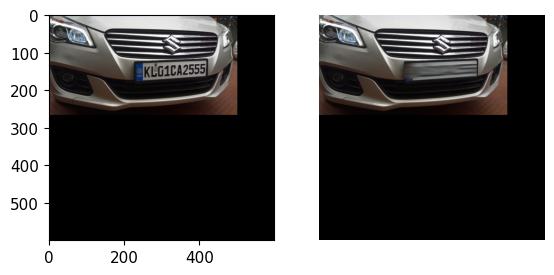

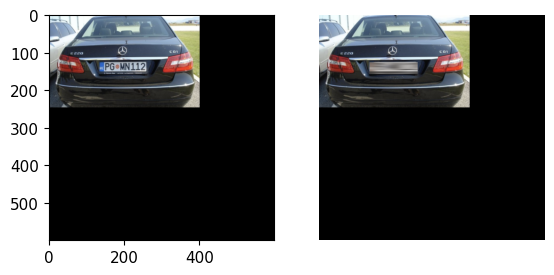

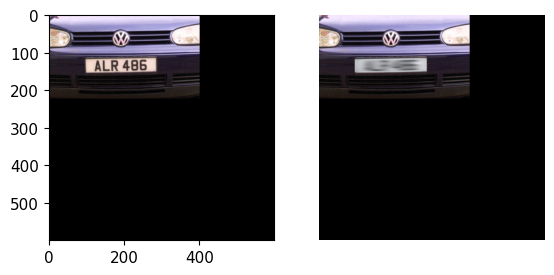

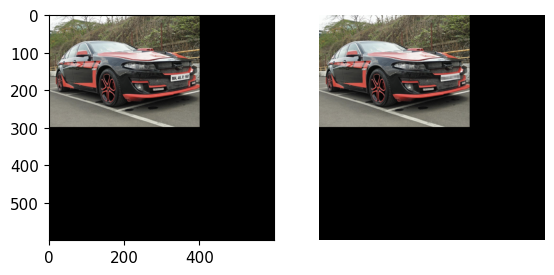

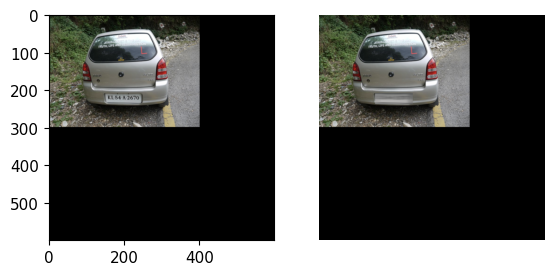

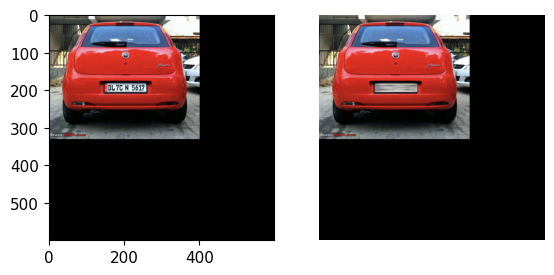

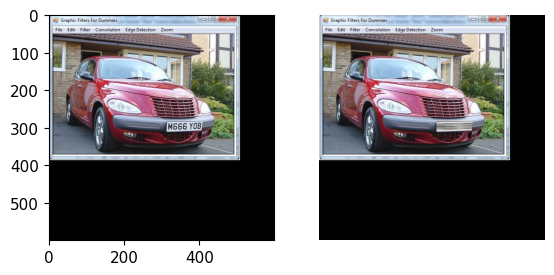

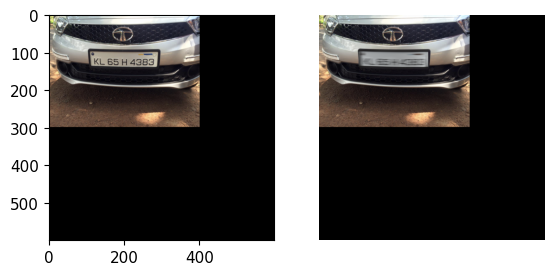

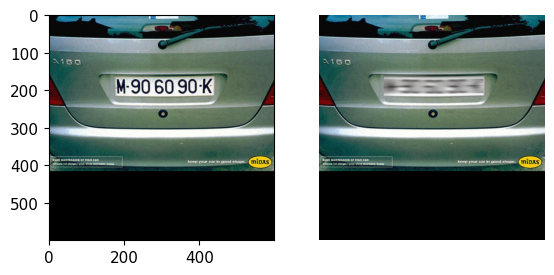

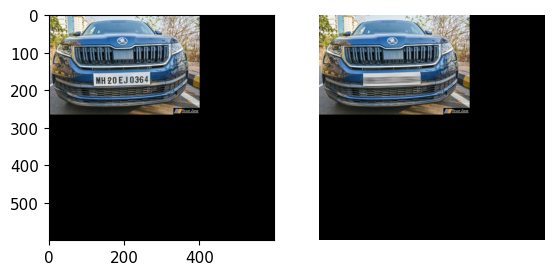

In [199]:
bounding_box_model = load_model_bounding()
blur_levels = []

for i in range(0, len(final_images)):
    for blur_level in range(0, num_blur_levels):
        # 1. Extracted text first
        # img_path = f"/content/drive/MyDrive/01-License Plates/croppedimages/CroppedCar{blur_level}.png"
        img_path = f"/content/drive/MyDrive/01-License Plates/croppedimages/CroppedCar{i}-{blur_level}.png"
        extracted_text = extract_license_plate_text(img_path)
        extracted_text_len = len([c for c in extracted_text if c.isalnum()])

        # 2. Check amount of extracted text
        if blur_level == num_blur_levels - 1:
            fig, ax = plt.subplots(1, 2)
            plt.axis("off")
            ax[0].imshow(plate_images[i][0])
            ax[1].imshow(final_images[i][0])
            print("Used blur level: 0")
            blur_levels.append(0)
        elif extracted_text_len < 2:
            print(f"Extracted text from - {img_path}: {extracted_text}")
            print(f"Number of alphanumeric characters {extracted_text_len}")
            continue
        else:
            print(f"Extracted text from - {img_path}: {extracted_text}")
            print(f"Number of alphanumeric characters {extracted_text_len}")

            fig, ax = plt.subplots(1, 2)
            plt.axis("off")
            ax[0].imshow(plate_images[i][0])
            ax[1].imshow(final_images[i][blur_level])
            print("Used blur level:", blur_level)
            blur_levels.append(blur_level)
            break

            # 2. Run YOLO model to show bounding box if the extracted text is empty
            # bounding_box_show(img_path, bounding_box_model)
            # break

# 4. Blur Level Distribution

Average blur level: 1.4


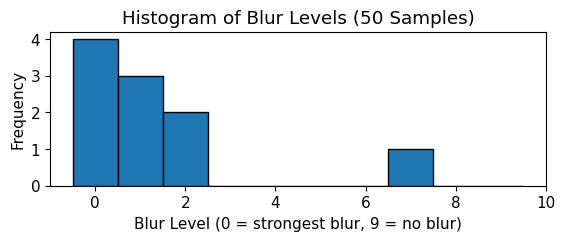

In [200]:
print("Average blur level:", sum(blur_levels)/len(blur_levels))

plt.figure().set_figheight(2)
plt.hist(blur_levels, bins=np.arange(11)-0.5, ec="k")
plt.xlabel("Blur Level (0 = strongest blur, 9 = no blur)")
plt.ylabel("Frequency")
plt.title("Histogram of Blur Levels (50 Samples)")

plt.show()